## Setup database connectivity

In [2]:
%run '../database_connectivity_setup.ipynb'

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `database_connectivity_setup.ipynb` notebook, use that connection object where needed.

#### Import the Necessary Python Packages

In [40]:
%matplotlib inline
import numpy as np
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

In [13]:
sql = """create schema mcmc;"""
psql.execute(sql,conn)
conn.commit()

### The Following UDFs need to be installed in the Greenplum or HAWQ database
### The GibbsProbit MPP implementation depends on numpy version 1.8.0 or above, scipy version 0.13.3 or above, and MADlib v 1.8
### This implementation is based on the paper:
Bayesian Analysis of Binary and Polychotomous Response Data, James H. Albert and Siddhartha Chib, Journal of the American Statistical Association, Vol. 88, No. 422 (Jun., 1993), pp. 669-679

#### PL/Python UDF that returns a sample from a truncated normal distribution. This is called on each row of the data to which the model is being fit.

In [15]:
sql = """drop function if exists mcmc.sample_truncated_normal(float8[],int,float8[]);"""
psql.execute(sql,conn)
conn.commit();

sql = """
    create or replace function mcmc.sample_truncated_normal(
        x_arr float8[],
        y int, 
        beta_arr float8[]
    )
    returns float8[]
    AS
    $$
        import numpy as np
        from scipy.stats import truncnorm
        x = np.array(x_arr)
        beta = np.transpose(np.array(beta_arr))
        mu = np.dot(x,beta)
        z = np.zeros(shape=1)
        if (y == 1):
            a = 0
            b = np.inf
            r = truncnorm.rvs(a-mu, b, loc = mu, size=1)
            z[0] = r[0]
        elif (y == 0):
            a = np.NINF
            b = 0
            r = truncnorm.rvs(a, b-mu, loc = mu, size=1)
            z[0] = r[0]
        return z
    $$ language plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

#### PL/Python UDF that returns a sample from a multivariate normal distribution. This takes in as input a mean vector and a covariance matrix. Current limitations are that both of these have to be less than 1 GB. This implies a floating point (8 byte per float) covariance matrix  of size approximately 10,000  x 10,000.  Since, the covariance matrix size is equal to the number of features, we should be good!

In [15]:
sql = """drop function if exists mcmc.sample_from_multivariate_normal(float8[], float8[], int);"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create or replace function mcmc.sample_from_multivariate_normal(
        mu float8[],
        cov float8[],
        ncols int
    )
    returns float8[]
    AS
    $$
        import numpy as np;
        from numpy.random import multivariate_normal
        mean = np.array(mu)
        cov_mat = np.matrix(cov).reshape(len(cov)/ncols, ncols)
        return multivariate_normal(mean=mean,cov=cov_mat,size =1).flatten().tolist()
    $$language plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

####PL/Python UDF that computes and returns a matrix inverse. Current limitation is that the input matrix has to be less than 1 GB. This implies a floating point (8 byte per float) matrix of size approximately 10,000 x 10,000. Since, the inverse matrix  is computed for matrices whose dimension is equal to the number of features, we should be good!

In [3]:
sql = """drop function if exists mcmc.compute_matrix_inverse(float8[], int);"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create or replace function mcmc.compute_matrix_inverse(
        matrix float8[],
        ncols int
    )
    returns SETOF float8[]
    AS
    $$
        import numpy as np;
        mat = np.matrix(matrix).reshape(len(matrix)/ncols, ncols)
        plpy.info(mat.shape)
        return np.linalg.inv(mat).tolist()
    $$language plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

#### User defined aggregate to aggregate 1-D arrays

In [19]:
sql = """DROP AGGREGATE IF EXISTS mcmc.array_agg_array(anyarray) CASCADE;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    CREATE ORDERED AGGREGATE mcmc.array_agg_array(anyarray)
    (
        SFUNC = array_cat,
        STYPE = anyarray
    );
"""
psql.execute(sql,conn)
conn.commit()

#### PL/Python UDF to compute the OLS estimate of a normal inear regression

In [58]:
sql = """drop function if exists mcmc.lin_regr_ols_estimate(varchar, varchar, varchar, varchar, varchar, varchar);"""
psql.execute(sql,conn)
conn.commit()

# Function arguments:
# x: name of the table that stores the data matrix
# x_rowid: row identifier column in the data matrix
# x_rowvec: row vector for a given row in the data matrix
# y: name of the table that stores the response vector
# y_rowid: row identifier column for each element in the response vector table
# y_rowvec: 1-D array storing each element in the response vector table

sql = """
    create or replace function mcmc.lin_regr_ols_estimate(
        x varchar,
        x_rowid varchar,
        x_rowvec varchar,
        y varchar,
        y_rowid varchar,
        y_rowvec varchar
    )
    returns float8[]
    AS
    $$
        plpy.execute('drop table if exists mcmc.x_t_x;')
        sqlstr = \"""
            select
                madlib.matrix_mult(
                    '{x_matrix}',
                    'row={xid}, val={xval}, trans=true',
                    '{x_matrix}',
                    'row={xid}, val={xval}',
                    'mcmc.x_t_x',
                    'row=row_id, val=row_vec'
                )
        \""".format(x_matrix=x, xid=x_rowid, xval=x_rowvec)
        plpy.execute(sqlstr)
        
        plpy.execute('drop table if exists mcmc.x_t_y;')
        sqlstr = \"""
            select
                madlib.matrix_mult(
                    '{x_matrix}',
                    'row={xid}, val={xval}, trans=true',
                    '{y_vector}',
                    'row={yid}, val={yval}',
                    'mcmc.x_t_y',
                    'row=row_id, val=element'
                )
        \""".format(
                x_matrix=x, 
                xid=x_rowid, 
                xval=x_rowvec, 
                y_vector=y, 
                yid=y_rowid, 
                yval=y_rowvec
            )
        plpy.execute(sqlstr)
        
        plpy.execute('drop table if exists x_t_x_inv;')
        sqlstr = \"""
            create temp table x_t_x_inv as (
                select
                    row_number() over() as row_id,
                    inv as row_vec
                from (
                    select
                        mcmc.compute_matrix_inverse (
                            m,
                            ncols
                        ) as inv 
                    from (
                        select
                            mcmc.array_agg_array(row_vec order by row_id) as m,
                            max(array_upper(row_vec, 1)) as ncols
                        from            
                            mcmc.x_t_x
                    )q1
                ) q
            ) distributed by (row_id);
        \"""
        plpy.execute(sqlstr)
        
        plpy.execute('drop table if exists mcmc.lin_regr_ols_estimate;')
        sqlstr = \"""
            select
                madlib.matrix_mult(
                    'x_t_x_inv',
                    'row=row_id, val=row_vec',
                    'mcmc.x_t_y',
                    'row=row_id, val=element',
                     'mcmc.lin_regr_ols_estimate',
                    'row=row_id, val=element'
                )
        \"""
        plpy.execute(sqlstr)
        
        sqlstr = \"""
            select 
                array_agg(ele order by row_id) as ols 
            from (
                select
                    row_id,
                    unnest(element) as ele
                from
                    mcmc.lin_regr_ols_estimate
            )q
        \"""
        rv = plpy.execute(sqlstr)
        return rv[0]['ols']
    $$ language plpythonu;
"""
psql.execute(sql,conn)
conn.commit();

#### PL/Python UDF to create an identity matrix

In [9]:
sql = """drop function if exists mcmc.create_identity_matrix(int);"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create or replace function mcmc.create_identity_matrix(
        n int
    )
    returns SETOF float8[]
    AS
    $$
        import numpy as np;
        return np.identity(n).tolist()
    $$language plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

#### PL/Python Gibbs Probit Driver Function

In [4]:
sql = """
    drop function if exists mcmc.GibbsProbit(
        varchar, 
        varchar,
        varchar,
        varchar,
        varchar,
        varchar,
        float8[], 
        varchar,
        varchar,
        varchar,
        int, 
        int
    );
"""
psql.execute(sql,conn)
conn.commit();

# Gibbs Probit Regression Driver Function
# Arguments:
# x - name of the table storing the data matrix
# x_rowid - the row identifier column in the x data matrix
# x_rowvec - the vector per row in the x data matrix stored as an array
# y - name of the table storing the response column vector (binary column, should be 1 and 0)
# y_rowid : the row identifier for each element of the y vector. y_rowid should match x_rowid
# y_element: a 1-Dimensional array containing the y vector values
# prior_beta_mu : the mean of the normal beta prior distribution supplied as an array
# prior_beta_cov : name of the table storing the covariance matrix of the normal beta prior distribution
# prior_beta_cov_rowid : the row identifier column in the prior_beta_cov table
# prior_beta_cov_rowvec : the vector per row in the prior_beta_cov matrix stored as an array 
# num : number of Gibbs iterations
# num_burnin_iter: number of burnin iterations

sql = """
    create or replace function mcmc.GibbsProbit(
        x varchar,
        x_rowid varchar,
        x_rowvec varchar,
        y varchar,
        y_rowid varchar,
        y_element varchar,
        prior_beta_mu float8[],
        prior_beta_cov varchar,
        prior_beta_cov_rowid varchar,
        prior_beta_cov_rowvec varchar,
        num_iter int,
        num_burnin_iter int
    )
    returns text
    AS
    $$
        import numpy as np
        from numpy.random import multivariate_normal
        
        plpy.execute('drop table if exists prior_beta_cov_inv;')
        sqlstr = \"""
            create temp table prior_beta_cov_inv as (
                select
                    row_number() over() as row_id,
                    inv as row_vec
                from (
                    select
                        mcmc.compute_matrix_inverse (
                            m,
                            ncols
                        ) as inv 
                    from (
                        select
                            mcmc.array_agg_array({val} order by {rowid}) as m,
                            max(array_upper({val}, 1)) as ncols
                        from            
                            {covtable}
                    )q1
                ) q
            ) distributed by (row_id);
        \""".format(
                val=prior_beta_cov_rowvec, 
                rowid=prior_beta_cov_rowid,
                covtable=prior_beta_cov
            )
        plpy.execute(sqlstr)
        
        plpy.execute('drop table if exists mcmc.x_t_x;')
        sqlstr = \"""
            select
                madlib.matrix_mult(
                    '{x_matrix}',
                    'row={xid}, val={xval}, trans=true',
                    '{x_matrix}',
                    'row={xid}, val={xval}',
                    'mcmc.x_t_x',
                    'row=row_id, val=row_vec'
                )
        \""".format(x_matrix=x, xid=x_rowid, xval=x_rowvec)
        plpy.execute(sqlstr)
        
        plpy.execute('drop table if exists mcmc.add_inv_cov_mat_x_t_x;')
        sqlstr = \"""
            select
                madlib.matrix_mult(
                    'prior_beta_cov_inv',
                    'row=row_id, val=row_vec',
                    'mcmc.x_t_x',
                    'row=row_id, val=row_vec',
                    'mcmc.add_inv_cov_mat_x_t_x',
                    'row=row_id, val=row_vec'
                )
        \"""
        plpy.execute(sqlstr)
        
        plpy.execute('drop table if exists b_tilda;')
        sqlstr = \"""
            create temp table b_tilda as (
                select
                    row_number() over() as row_id,
                    inv as row_vec
                from (
                    select
                        mcmc.compute_matrix_inverse (
                            m,
                            ncols
                        ) as inv 
                    from (
                        select
                            mcmc.array_agg_array(row_vec order by row_id) as m,
                            max(array_upper(row_vec, 1)) as ncols
                        from            
                            mcmc.add_inv_cov_mat_x_t_x
                    )q1
                ) q
            ) distributed by (row_id);
        \"""
        plpy.execute(sqlstr)

        sqlstr = \"""
            select
                madlib.matrix_vec_mult(
                    'prior_beta_cov_inv', 
                    'row=row_id, val=row_vec',
                    array{prior_beta_mu_vec})
                as row_vec;
        \""".format(prior_beta_mu_vec=prior_beta_mu)
        rv = plpy.execute(sqlstr)
        
        sqlstr = \"""
            select
                madlib.matrix_vec_mult(
                    'b_tilda', 
                    'row=row_id, val=row_vec',
                    array{vec})
                as row_vec;
        \""".format(vec=rv[0]['row_vec'])
        rv = plpy.execute(sqlstr)   
        beta_tilda_part1 = rv[0]['row_vec'] # This will be in memory. Should be ok
        # as this has dimensions = number features.
        
        sqlstr = \"""
            select 
                mcmc.lin_regr_ols_estimate(
                    '{x_matrix}', 
                    '{x_rowid}', 
                    '{x_rowvec}', 
                    '{y_vector}', 
                    '{y_rowid}', 
                    '{y_element}'
                ) as ols;
        \""".format(
                x_matrix=x,
                x_rowid=x_rowid,
                x_rowvec=x_rowvec,
                y_vector=y,
                y_rowid=y_rowid,
                y_element=y_element
        )
        rv = plpy.execute(sqlstr)
        beta = rv[0]['ols']
        coeffs = np.zeros(shape=(num_iter-num_burnin_iter,len(beta)))
        coefindx = 0
        plpy.info('Entering Gibbs Iterations')
        plpy.execute('drop table if exists mcmc.gibbstrace;')
        plpy.execute('create table mcmc.gibbstrace(iter_num int, beta float8[]) distributed by (iter_num);')
        
        for ite in range(0,num_iter):
            plpy.info('Iteration number: {ite}'.format(ite=ite))
            plpy.execute('drop table if exists mcmc.zvec;')
            plpy.execute(\"""
                create table mcmc.zvec(row_id int, element float8[]) distributed by(row_id);
                \""")
            sqlstr = \"""
                insert into mcmc.zvec (
                    select
                        t2.{y_rowid} as row_id,
                        mcmc.sample_truncated_normal(
                            t1.{x_rowvec},
                            unnest(t2.{y_element})::int,
                            array{betavec}::float8[]
                        ) as element
                    from 
                        {x_table} as t1, 
                        {y_table} as t2 
                    where t1.{x_rowid} = t2.{y_rowid}
                );
            \""".format(
                    x_rowvec=x_rowvec,
                    y_element=y_element,
                    betavec=beta,
                    x_table=x,
                    y_table=y,
                    x_rowid=x_rowid,
                    y_rowid=y_rowid
                )
            plpy.execute(sqlstr)
            
            plpy.execute('drop table if exists mcmc.x_t_z;')
            sqlstr = \"""
                select
                    madlib.matrix_mult(
                        '{x_matrix}',
                        'row={xid}, val={xval}, trans=true',
                        'mcmc.zvec',
                        'row=row_id, val=element',
                        'mcmc.x_t_z',
                        'row=row_id, val=element'
                    )
            \""".format(
                    x_matrix=x, 
                    xid=x_rowid, 
                    xval=x_rowvec
                )
            plpy.execute(sqlstr)
            
            plpy.execute('drop table if exists mcmc.b_tilda_x_t_z;')
            sqlstr = \"""
                select
                    madlib.matrix_mult(
                        'b_tilda',
                        'row=row_id, val=row_vec',
                        'mcmc.x_t_z',
                        'row=row_id, val=element',
                        'mcmc.b_tilda_x_t_z',
                        'row=row_id, val=element'
                    )
            \"""
            plpy.execute(sqlstr)
            
            sqlstr = \"""
                select
                    array_agg(element order by row_id) as row_vec
                from (
                    select
                        row_id,
                        unnest(element)::float8 as element
                     from
                        mcmc.b_tilda_x_t_z
                ) q; 
            \"""
            rv = plpy.execute(sqlstr)   
            # This will be in memory. Should be ok
            # as this has dimensions = number features.
            b_tilda_x_t_z = rv[0]['row_vec'] 
            
            # This will be in memory. Should be ok
            # as this has dimensions = number features.
            beta_tilda = np.array(beta_tilda_part1).flatten() + np.array(b_tilda_x_t_z).flatten()

            sqlstr = \"""
                select
                    mcmc.sample_from_multivariate_normal (
                        array{beta_tilda},
                        cov,
                        ncols
                    ) as sample 
                from (
                    select
                        mcmc.array_agg_array(row_vec order by row_id) as cov,
                        max(array_upper(row_vec, 1)) as ncols
                    from            
                        b_tilda
                )q;
            \""".format(beta_tilda=beta_tilda.tolist())
            rv = plpy.execute(sqlstr)
            beta = rv[0]['sample'] # This will be in memory. Should be ok
            # as this has dimensions = number features.
            if (ite >= num_burnin_iter):
                sqlstr = \"""
                    insert into mcmc.gibbstrace values ({ite},array{beta});
                \""".format(ite=ite,beta=beta)
                plpy.execute(sqlstr)
            
        return 'Gibbs coeffieicent trace stored in table mcmc.gibbstrace'
    $$ language plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

### Let us now test this MPP implementation on the Lung Cancer Remission Dataset.
### The data set can be downloaded from http://www.ats.ucla.edu/stat/data/hdp.csv

In [6]:
sql = """drop table if exists mcmc.lung_cancer_data;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table mcmc.lung_cancer_data (
        tumorsize float8,
        co2 float8,
        pain float8,
        wound float8,
        mobility float8,
        ntumors float8,
        nmorphine float8,
        lungcapacity float8,
        Age float8,
        Married int,
        Sex varchar,
        WBC float8,
        RBC float8,
        BMI float8,
        IL6 float8,
        CRP float8,
        remission int
    ) distributed randomly;
"""
psql.execute(sql,conn)
conn.commit()

#### Run this copy command on the psql prompt
` COPY mcmc.lung_cancer_data FROM '/home/gpadmin/data/lung_cancer_remission_db.csv' CSV HEADER DELIMITER ',' NULL '';`

In [7]:
psql.read_sql('select count(*) from mcmc.lung_cancer_data;',conn)

,count
0,8525


In [8]:
sql = """drop table if exists mcmc.gibbs_lung_cancer_data;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table mcmc.gibbs_lung_cancer_data as (
        select
            row_number() over() as rowid,
            *
        from
            mcmc.lung_cancer_data
        
    ) distributed randomly;
"""
psql.execute(sql,conn)
conn.commit()

In [9]:
psql.read_sql('select count(*) from mcmc.gibbs_lung_cancer_data;',conn)

,count
0,8525


In [10]:
sql = """drop table if exists mcmc.x;"""
psql.execute(sql,conn)
conn.commit()

sql = """drop table if exists mcmc.x_std;"""
psql.execute(sql,conn)
conn.commit()

sql = """drop table if exists mcmc.y;"""
psql.execute(sql,conn)
conn.commit()

sql = """drop table if exists mcmc.prior_beta_cov;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table mcmc.x as (
        select
            rowid,
            array[
                1,
                (tumorsize - (avg(tumorsize) OVER()))/(stddev(tumorsize) OVER()),
                (co2 - (avg(co2) OVER()))/(stddev(co2) OVER()), 
                (pain - (avg(pain) OVER()))/(stddev(pain) OVER()), 
                (wound - (avg(wound) OVER()))/(stddev(wound) OVER()), 
                (mobility - (avg(mobility) OVER()))/(stddev(mobility) OVER()),  
                (ntumors - (avg(ntumors) OVER()))/(stddev(ntumors) OVER()), 
                (nmorphine - (avg(nmorphine) OVER()))/(stddev(nmorphine) OVER()), 
                (lungcapacity - (avg(lungcapacity) OVER()))/(stddev(lungcapacity) OVER()), 
                (age - (avg(age) OVER()))/(stddev(age) OVER()), 
                (BMI - (avg(BMI) OVER()))/(stddev(BMI) OVER())
            ]::float8[] as row_vec
        from
            mcmc.gibbs_lung_cancer_data
        
    ) distributed by (rowid);
"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table mcmc.y as (
        select
            rowid,
            array[
                remission
            ]::float8[] as element
        from
            mcmc.gibbs_lung_cancer_data
        
    ) distributed by (rowid);
"""

psql.execute(sql,conn)
conn.commit()

sql = """
    create table mcmc.prior_beta_cov as (
        select 
            row_number() over() as row_id,
            row_vec
        from (
            select
                mcmc.create_identity_matrix(11) as row_vec
        )q
    ) distributed by (row_id);
"""
psql.execute(sql,conn)
conn.commit()

In [ ]:
sql = """
    select 
        mcmc.GibbsProbit(
        'mcmc.x',
        'rowid', 
        'row_vec', 
        'mcmc.y', 
        'rowid', 
        'element', 
        array[0,0,0,0,0,0,0,0,0,0,0]::float8[], 
        'mcmc.prior_beta_cov', 
        'row_id',
        'row_vec',
        500,
        50);
"""
psql.execute(sql,conn)
conn.commit()

In [34]:
# Let us now retrieve the Gibbs coefficient trace
sql = """select iter_num, beta from mcmc.gibbstrace order by iter_num;"""
df = psql.read_sql(sql,conn)
coeffs = np.array(df.beta.tolist())

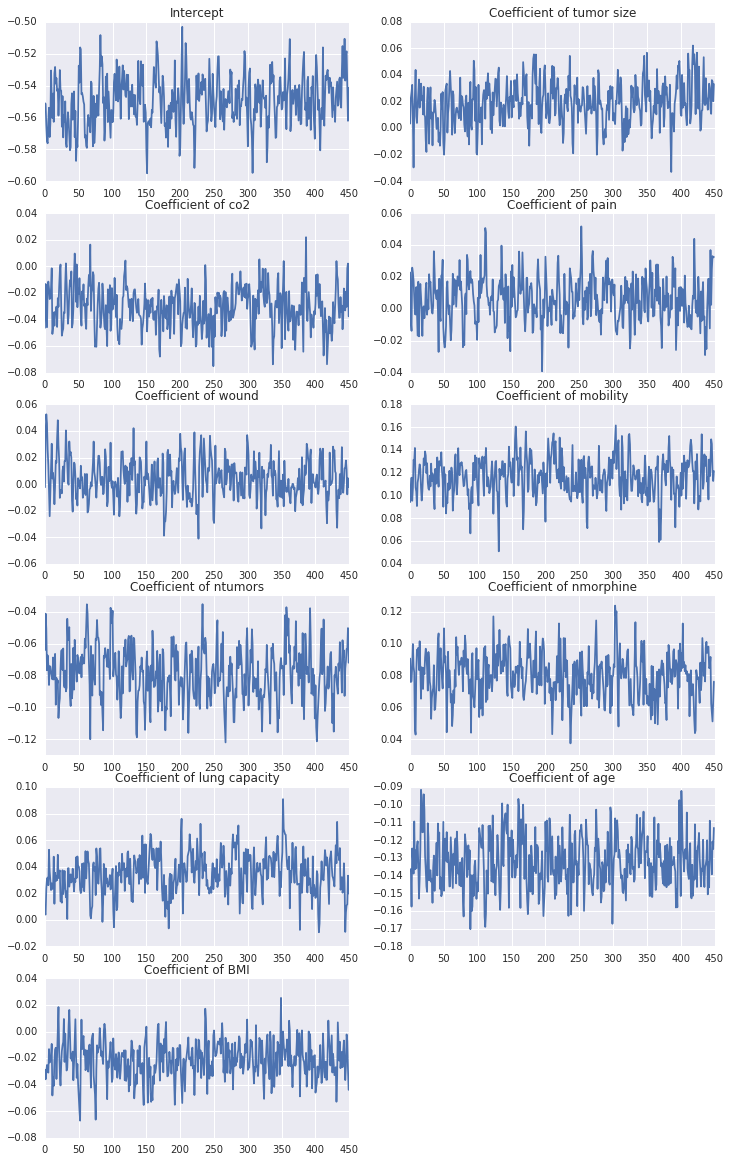

In [37]:
# Plot the coefficients
f, axarr = plt.subplots(6,2)
f.patch.set_facecolor('white')
f.set_size_inches(12,20)
axarr[0,0].plot(range(0,coeffs.shape[0]),coeffs[:,0])
axarr[0,0].set_title('Intercept')
axarr[0,1].plot(range(0,coeffs.shape[0]),coeffs[:,1])
axarr[0,1].set_title('Coefficient of tumor size')
axarr[1,0].plot(range(0,coeffs.shape[0]),coeffs[:,2])
axarr[1,0].set_title('Coefficient of co2')
axarr[1,1].plot(range(0,coeffs.shape[0]),coeffs[:,3])
axarr[1,1].set_title('Coefficient of pain')
axarr[2,0].plot(range(0,coeffs.shape[0]),coeffs[:,4])
axarr[2,0].set_title('Coefficient of wound')
axarr[2,1].plot(range(0,coeffs.shape[0]),coeffs[:,5])
axarr[2,1].set_title('Coefficient of mobility')
axarr[3,0].plot(range(0,coeffs.shape[0]),coeffs[:,6])
axarr[3,0].set_title('Coefficient of ntumors')
axarr[3,1].plot(range(0,coeffs.shape[0]),coeffs[:,7])
axarr[3,1].set_title('Coefficient of nmorphine')
axarr[4,0].plot(range(0,coeffs.shape[0]),coeffs[:,8])
axarr[4,0].set_title('Coefficient of lung capacity')
axarr[4,1].plot(range(0,coeffs.shape[0]),coeffs[:,9])
axarr[4,1].set_title('Coefficient of age')
axarr[5,0].plot(range(0,coeffs.shape[0]),coeffs[:,10])
axarr[5,0].set_title('Coefficient of BMI')
axarr[5,1].axis('off')
plt.show()

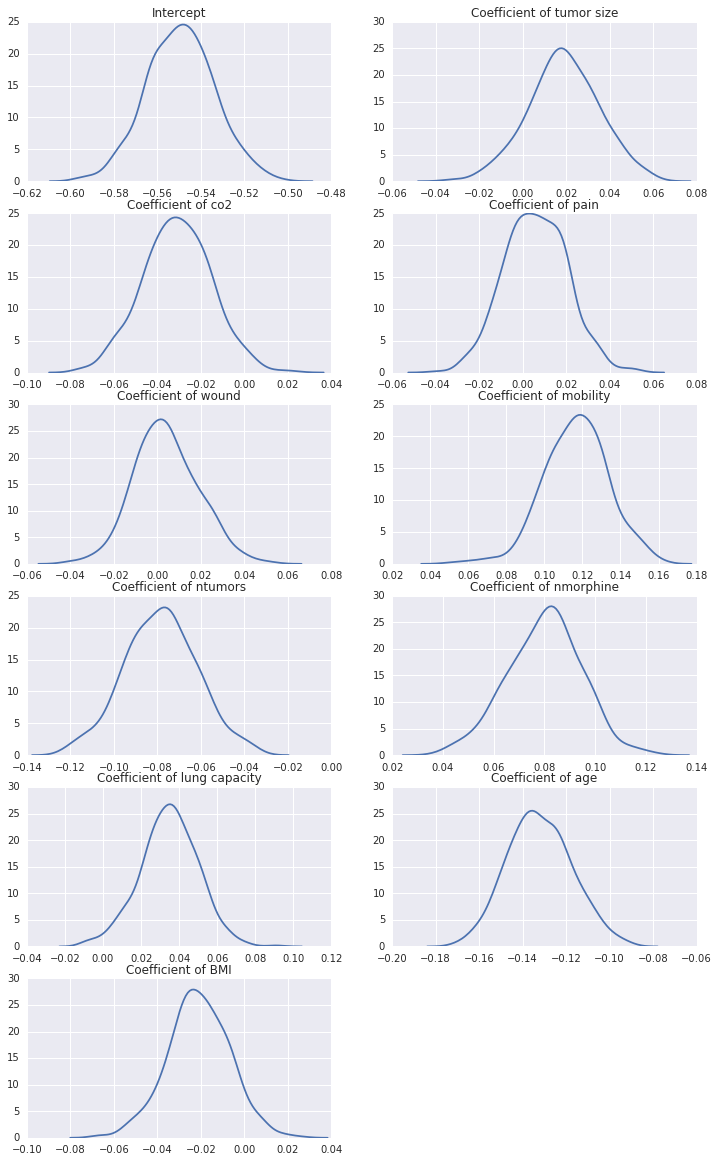

In [38]:
# Plot the coefficient density
# Let us inspect the coefficients now
f, axarr = plt.subplots(6,2)
f.patch.set_facecolor('white')
f.set_size_inches(12,20)
sns.kdeplot(coeffs[:,0], ax=axarr[0,0])
axarr[0,0].set_title('Intercept')
sns.kdeplot(coeffs[:,1],ax=axarr[0,1])
axarr[0,1].set_title('Coefficient of tumor size')
sns.kdeplot(coeffs[:,2], ax=axarr[1,0])
axarr[1,0].set_title('Coefficient of co2')
sns.kdeplot(coeffs[:,3],ax=axarr[1,1])
axarr[1,1].set_title('Coefficient of pain')
sns.kdeplot(coeffs[:,4],ax=axarr[2,0])
axarr[2,0].set_title('Coefficient of wound')
sns.kdeplot(coeffs[:,5],ax=axarr[2,1])
axarr[2,1].set_title('Coefficient of mobility')
sns.kdeplot(coeffs[:,6],ax=axarr[3,0])
axarr[3,0].set_title('Coefficient of ntumors')
sns.kdeplot(coeffs[:,7],ax=axarr[3,1])
axarr[3,1].set_title('Coefficient of nmorphine')
sns.kdeplot(coeffs[:,8],ax=axarr[4,0])
axarr[4,0].set_title('Coefficient of lung capacity')
sns.kdeplot(coeffs[:,9],ax=axarr[4,1])
axarr[4,1].set_title('Coefficient of age')
sns.kdeplot(coeffs[:,10],ax=axarr[5,0])
axarr[5,0].set_title('Coefficient of BMI')
axarr[5,1].axis('off')
plt.show()

In [39]:
# What are the mean and median coeffs
beta_mean = np.mean(coeffs,axis=0)
beta_median = np.median(coeffs,axis=0)
print beta_mean
print beta_median

[-0.54930722  0.01896635 -0.03098508  0.00603133  0.0040766   0.11670125
 -0.07843823  0.08000492  0.03478603 -0.13210797 -0.02104419]
[-0.54921032  0.01847767 -0.03076114  0.00560091  0.00311003  0.1172528
 -0.07794939  0.08088648  0.0355637  -0.13303746 -0.02110162]


In [41]:
# Close DB connection
conn.close()